In [1]:
import os
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
SCN=1
SCNstr="1"

In [2]:
#Reading Data from files
def extractScores(nodes):
    nodeAcc=dict()
    for node in nodes:
        with open(node,'r', encoding='utf-8') as f:
            nodeAcc[int(node.split('/')[::-1][0])]=float(f.readline())
    return nodeAcc
nodes=[x for x in glob.glob(SCNstr+'/NodeFinals/NodeAcc/**')]
nodeAcc=extractScores(nodes)
nodes=[x for x in glob.glob(SCNstr+'/RSUFinals/NodeAcc/std/**')]
RSUNodeAcc=extractScores(nodes)
nodes=[x for x in glob.glob(SCNstr+'/RSUFinals/NodeAcc/WOBL/**')]
RSUNodeAccWOBL=extractScores(nodes)
nodes=[x for x in glob.glob(SCNstr+'/RSUFinals/NodeAcc/RB/**')]
RSUNodeAccRB=extractScores(nodes)
#nodeAcc={i[0]:i[1] for i in sorted(nodeAcc.items(), key = lambda kv:(kv[1], kv[0]))}

nodes=[x for x in glob.glob(SCNstr+'/NodeFinals/NodeRepAcc/**')]
nodeRepAcc=extractScores(nodes)

class secScoreReord:
    def __init__(self, st,sc,bl):
        self.stage=st
        self.score=sc
        self.blacklisted=bl
    
nodes=[x for x in glob.glob(SCNstr+'/RSUFinals/NodeSecScore/**')]
RSUNodeSSs=dict()
for node in nodes:
    with open(node,'r', encoding='utf-8') as f:
        SSs=f.readlines() 
        RSUNodeSSs[int(node.split('/')[3])]=[secScoreReord(int(i.split(',')[0]),float(i.split(',')[1]),int(i.split(',')[2])) for i in SSs]

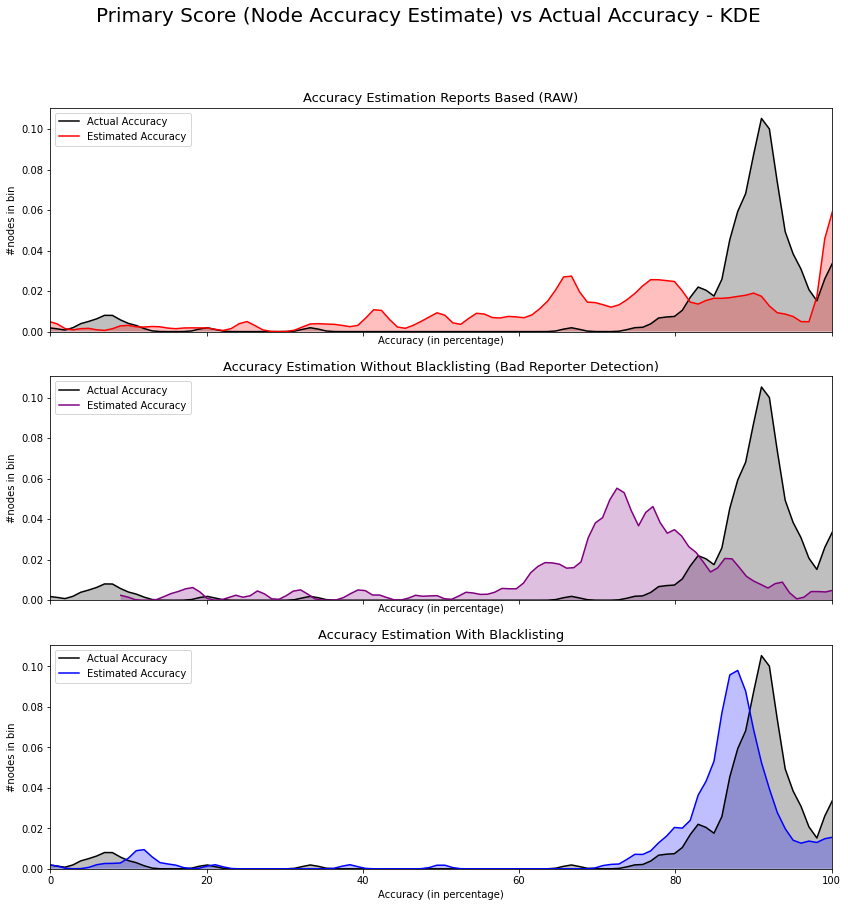

In [3]:
# PrimaryScores (Accuracy Estimates) KDE VS Actual Scores KDE Comparison
f, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True)
#sns.despine(left=True)
f.suptitle("Primary Score (Node Accuracy Estimate) vs Actual Accuracy - KDE", 
           fontsize=20, 
           fontweight=500,
           variant='small-caps'
          )
for ax in axes.flat:
    ax.set(xlabel="Accuracy (in percentage)", ylabel="#nodes in bin", xlim=(0,100))
    sns.kdeplot([nodeAcc[i]*100 for i in nodeAcc], ax=ax,  bw=.05, shade=True, 
                color='black', 
                label='Actual Accuracy')
    
axes[0].set_title("Accuracy Estimation Reports Based (RAW)",
                  fontweight=300,
                  size=13)
axes[1].set_title("Accuracy Estimation Without Blacklisting (Bad Reporter Detection)",
                  fontweight=300,
                  size=13)
axes[2].set_title("Accuracy Estimation With Blacklisting",
                  fontweight=300,
                  size=13)

sns.kdeplot([RSUNodeAcc[i]*100 for i in RSUNodeAcc], bw=.05, ax=axes[2], shade=True, 
            color='blue', 
            label='Estimated Accuracy')
sns.kdeplot([RSUNodeAccWOBL[i]*100 for i in RSUNodeAcc], bw=.05, ax=axes[1], shade=True, 
            color='purple', 
            label='Estimated Accuracy')
sns.kdeplot([RSUNodeAccRB[i]*100 for i in RSUNodeAcc], bw=.05, ax=axes[0], shade=True, 
            color='red', 
            label='Estimated Accuracy')

plt.legend()
f.savefig("/home/rohan/veins-5.0/examples/myProj1/plots/SCN"+SCNstr+"_PrimaryScoreKDEComparitive.svg")
#sns.distplot([nodeAcc[i] for i in nodeAcc],bins=15, label='Actual Accuracy')
#sns.distplot([RSUNodeAcc[i] for i in RSUNodeAcc], bins=15, label='Accuracy Estimation')

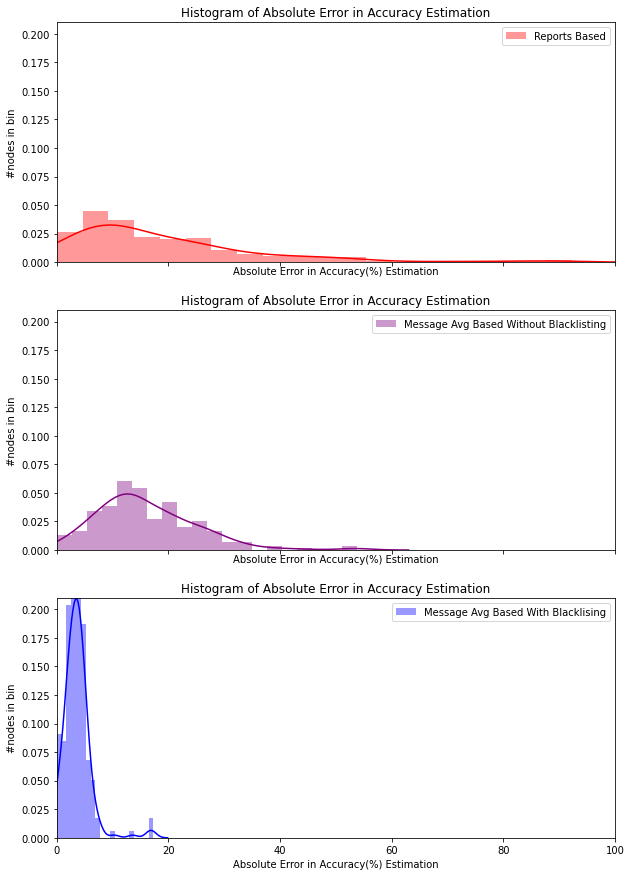

In [4]:
# Absolute Errors in Accuracy Estimation KDE Comparison
def calcError(nodeAcc,RSUNodeAcc):
    errors=[]
    noEval=0
    lessThan={1:0,5:0,10:0,15:0,20:0,25:0,30:0,35:0}
    for i in nodeAcc.keys():
        if i in RSUNodeAcc.keys():
            error=abs(RSUNodeAcc[i]-nodeAcc[i])*100
            errors.append(error)
            for i in lessThan.keys():
                if error<=i:
                    lessThan[i]+=1
        else:
            noEval+=1
    prcOfErrorsLessThan=dict()
    ct=0
    for i in sorted(errors):
        ct+=1
        p=100*float(ct)/float(len(nodeAcc)-noEval)
        prcOfErrorsLessThan[i]=p
    prcOfErrorsLessThan[100]=100
    return (errors,noEval,lessThan,prcOfErrorsLessThan)

(errors,noEval,lessThan,prcOfErrorsLessThan)=calcError(nodeAcc,RSUNodeAcc)
(WOBL_errors,WOBL_noEval,WOBL_lessThan,WOBL_prcOfErrorsLessThan)=calcError(nodeAcc,RSUNodeAccWOBL)
(RB_errors,RB_noEval,RB_lessThan,RB_prcOfErrorsLessThan)=calcError(nodeAcc,RSUNodeAccRB)

f, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
for ax in axes.flat:
    ax.set(xlabel="Absolute Error in Accuracy(%) Estimation",
           ylabel="#nodes in bin",
           title="Histogram of Absolute Error in Accuracy Estimation",
           ylim=(0,0.21),
           xlim=(0,100))
    
sns.distplot(errors,  bins=20, ax=axes[2],
             color='blue',
             label='Message Avg Based With Blacklising')
sns.distplot(WOBL_errors,  bins=20, ax=axes[1],
             color='purple',
             label='Message Avg Based Without Blacklisting')
sns.distplot(RB_errors,  bins=20, ax=axes[0],
             color='red',
             label='Reports Based')
for ax in axes.flat:
    ax.legend()
#plt.legend()
f.savefig("/home/rohan/veins-5.0/examples/myProj1/plots/SCN"+SCNstr+"_AbsoluteErrorsInEstimationHistogramComparison.svg")


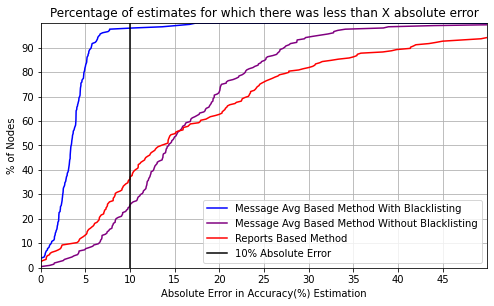

In [5]:
f=plt.figure(figsize=(8, 4.5))
ax=f.gca()
ax.set_title("Percentage of estimates for which there was less than X absolute error")
ax.set_ylabel("% of Nodes")
ax.set_xlabel("Absolute Error in Accuracy(%) Estimation")
ax.set_ylim((0,100))
ax.set_xlim((0,50))
ax.set_xticks(np.arange(0, 50, 5))
ax.set_yticks(np.arange(0, 100, 10))
plt.grid(b=True,which='both',axis='both')
ax.plot([float(i) for i in prcOfErrorsLessThan.keys()],
         [float(i) for i in prcOfErrorsLessThan.values()],
         color='blue',
         label="Message Avg Based Method With Blacklisting")
ax.plot([float(i) for i in WOBL_prcOfErrorsLessThan.keys()],
         [float(i) for i in WOBL_prcOfErrorsLessThan.values()],
         color='purple',
         label="Message Avg Based Method Without Blacklisting")
ax.plot([float(i) for i in RB_prcOfErrorsLessThan.keys()],
         [float(i) for i in RB_prcOfErrorsLessThan.values()],
         color='red',
         label="Reports Based Method")
ax.plot([10,10],
         [0,100],
         color='black',
         label="10% Absolute Error")
l=ax.legend()
f.savefig("/home/rohan/veins-5.0/examples/myProj1/plots/SCN"+SCNstr+"_AbsoluteErrorsInEstimationComparison.svg")

In [6]:
def printNA(f,s):
    print(s)
    return f+"\n"+s
def printPrcOfErrorsLessThans(nodeAcc, noEval, lessThan, name):
    f=''
    f=printNA(f,"\n\n###\t\t"+name+"\t\t###|")
    f=printNA(f,'|'+"-"*63+'|')
    f=printNA(f,"|\tNodes evaluated:\t"+str(len(nodeAcc)-noEval)+"/"+str(len(nodeAcc))+"\t\t\t\t|")
    f=printNA(f,"|\t\t("+str(round(float(len(nodeAcc)-noEval)*100/float(len(nodeAcc)),2))+"% of Total Nodes)\t\t\t\t|")
    f=printNA(f,'|'+"_"*63+'|')
    f=printNA(f,"|\t\t\t\t\t|#nodes\t|%nodes *\t|")
    f=printNA(f,'|'+"-"*63+'|')
    for i in lessThan.keys():
        f=printNA(f,"| Estimates Within "+str(i).zfill(2)+"% of Actual:\t|"+str(lessThan[i])+"\t|"+str(round(float(lessThan[i])*100/float(len(nodeAcc)-noEval),1))+"%\t\t|")      
    f=printNA(f,'|'+"-"*63+'|')
    f=printNA(f," *= (of those evaluated)")
    return f
f=open("/home/rohan/veins-5.0/examples/myProj1/plots/SCN"+SCNstr+"_EstimatesErrorCommulative.txt","w+")
f.write(printPrcOfErrorsLessThans(nodeAcc,RB_noEval,RB_lessThan, "Report Based"))
f.write(printPrcOfErrorsLessThans(nodeAcc,WOBL_noEval,WOBL_lessThan, "Without Blacklisting"))
f.write(printPrcOfErrorsLessThans(nodeAcc,noEval,lessThan,"With Blacklisting"))
f.close()



###		Report Based		###|
|---------------------------------------------------------------|
|	Nodes evaluated:	204/206				|
|		(99.03% of Total Nodes)				|
|_______________________________________________________________|
|					|#nodes	|%nodes *	|
|---------------------------------------------------------------|
| Estimates Within 01% of Actual:	|11	|5.4%		|
| Estimates Within 05% of Actual:	|27	|13.2%		|
| Estimates Within 10% of Actual:	|74	|36.3%		|
| Estimates Within 15% of Actual:	|111	|54.4%		|
| Estimates Within 20% of Actual:	|128	|62.7%		|
| Estimates Within 25% of Actual:	|155	|76.0%		|
| Estimates Within 30% of Actual:	|166	|81.4%		|
| Estimates Within 35% of Actual:	|175	|85.8%		|
|---------------------------------------------------------------|
 *= (of those evaluated)


###		Without Blacklisting		###|
|---------------------------------------------------------------|
|	Nodes evaluated:	204/206				|
|		(99.03% of Total Nodes)				|
|__________________________________________

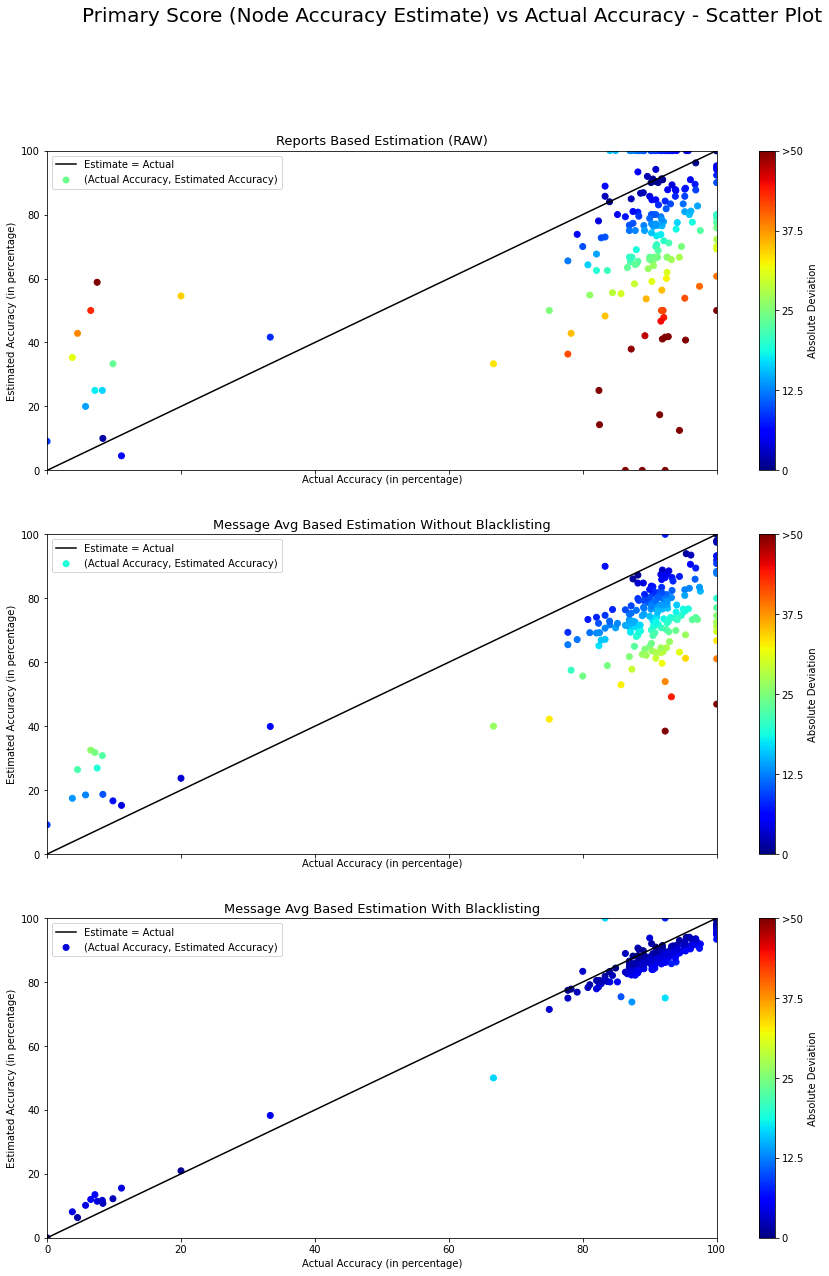

In [7]:
# Comparison of Actual Accuracy with Primary Score (Estimated Accuracy)
def getLists(Na,RNa):
    nl=[]
    rl=[]
    cv=[]
    noEval=0
    for i in Na.keys():
        if i in RNa.keys():
            nl.append(Na[i]*100)
            rl.append(RNa[i]*100)
            cv.append(plt.get_cmap('jet')(2*abs(RNa[i]-Na[i])))
        else:
            noEval==1
    return (nl,rl,cv,noEval)

(nl,rl,cv,noEval)=getLists(nodeAcc,RSUNodeAcc)
(WOBL_nl,WOBL_rl,WOBL_cv,WOBL_noEval)=getLists(nodeAcc,RSUNodeAccWOBL)
(RB_nl,RB_rl,RB_cv,RB_noEval)=getLists(nodeAcc,RSUNodeAccRB)

f, axes = plt.subplots(3, 1, figsize=(15, 20), sharex=True)
#sns.despine(left=True)
f.suptitle("Primary Score (Node Accuracy Estimate) vs Actual Accuracy - Scatter Plot", 
           fontsize=20, 
           fontweight=500,
           variant='small-caps'
          )
ims=[]
axes[0].set_title("Reports Based Estimation (RAW)",
                  fontweight=300,
                  size=13)
ims.append((axes[0],axes[0].scatter(RB_nl,RB_rl,c=RB_cv, label="(Actual Accuracy, Estimated Accuracy)")))

axes[1].set_title("Message Avg Based Estimation Without Blacklisting",
                  fontweight=300,
                  size=13)
ims.append((axes[1],axes[1].scatter(WOBL_nl,WOBL_rl,c=WOBL_cv, label="(Actual Accuracy, Estimated Accuracy)")))
axes[2].set_title("Message Avg Based Estimation With Blacklisting",
                  fontweight=300,
                  size=13)
ims.append((axes[2],axes[2].scatter(nl,rl,c=cv, label="(Actual Accuracy, Estimated Accuracy)")))
for (ax,im) in ims:
    ax.set(xlabel="Actual Accuracy (in percentage)", ylabel="Estimated Accuracy (in percentage)", xlim=(0,100), ylim=(0,100))
    ax.plot([0,100],[0,100],color='black',label="Estimate = Actual")
    ax.legend()
    im.set_cmap('jet')
    cbar=f.colorbar(im,ax=ax,ticks=[0, 0.25, 0.5, 0.75, 1])
    cbar.set_label("Absolute Deviation")
    cbar.ax.set_yticklabels(['0', '12.5', '25', '37.5', '>50'])
    
plt.legend()
f.savefig("/home/rohan/veins-5.0/examples/myProj1/plots/SCN"+SCNstr+"_PrimaryScoreVsActualAccuracyComparitive.svg")


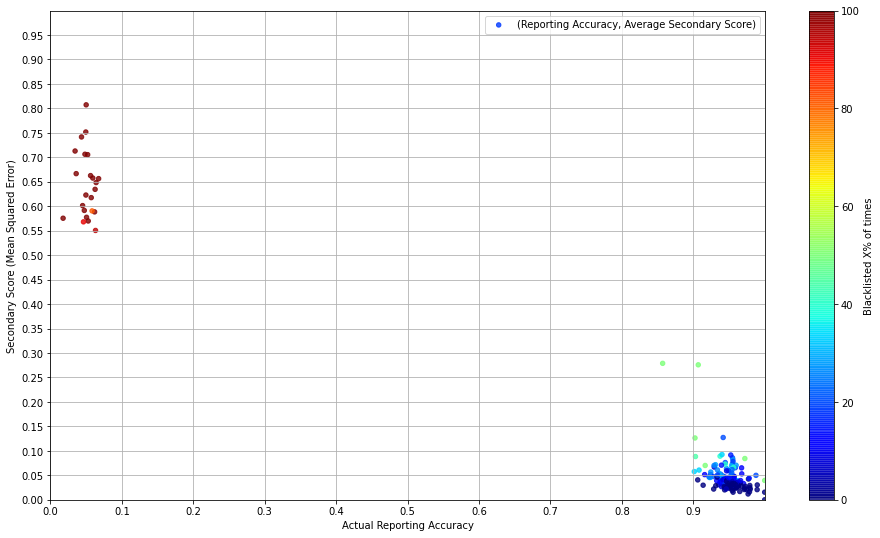

In [8]:
# Comparison of Actual Reporting Accuracy with Secondary Score 
skipFirstSecScore=False

class evaluatedNode:
    def __init__(self,rl,rsuAv,bk):
        self.real=rl
        self.RSUAvg=rsuAv
        self.colour=plt.get_cmap('jet')(bk)

evaluatedNodes=dict()
noEval=0
for i in nodeRepAcc.keys():
    if i in RSUNodeSSs.keys():
        if skipFirstSecScore:
            if len(RSUNodeSSs[i][1:])>1:
                av= (sum([j.score for j in RSUNodeSSs[i][1:]])/len(RSUNodeSSs[i][1:]))
                rl= nodeRepAcc[i]
                bk= (sum([j.blacklisted for j in RSUNodeSSs[i][1:]])/len(RSUNodeSSs[i][1:]))
                evaluatedNodes[i]=evaluatedNode(rl,av,bk)
            else:
                noEval+=1
        else:
            av= (sum([j.score for j in RSUNodeSSs[i]])/len(RSUNodeSSs[i]))
            rl= nodeRepAcc[i]
            bk= (sum([j.blacklisted for j in RSUNodeSSs[i]])/len(RSUNodeSSs[i]))
            evaluatedNodes[i]=evaluatedNode(rl,av,bk)
    else:
        noEval+=1
     
        

        
fig=plt.figure(figsize=(16,9))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1, 0.1))
ax.set_yticks(np.arange(0, 1, 0.05))
ax.grid(b=True,which='both',axis='both')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Actual Reporting Accuracy")
ax.set_ylabel("Secondary Score (Mean Squared Error)")
im=ax.scatter([i.real for i in evaluatedNodes.values()],
            [i.RSUAvg for i in evaluatedNodes.values()],
            s=20,
            c=[i.colour for i in evaluatedNodes.values()],
            label='(Reporting Accuracy, Average Secondary Score)',
            alpha=0.8)
im.set_cmap('jet')
cbar=f.colorbar(im, ax=ax)
cbar.set_label("Blacklisted X% of times")
cbar.ax.set_yticklabels(['0', '20', '40', '60', '80','100'])

'''ax.hexbin([i.real for i in evaluatedNodes.values()],
          [i.RSUAvg for i in evaluatedNodes.values()],
          gridsize=20,
          bins='log',
          cmap='inferno')'''
ax.legend()
f.savefig('/home/rohan/veins-5.0/examples/myProj1/plots/SCN'+SCNstr+'_ReportingAccuracy_Vs_SecondaryScore.svg')



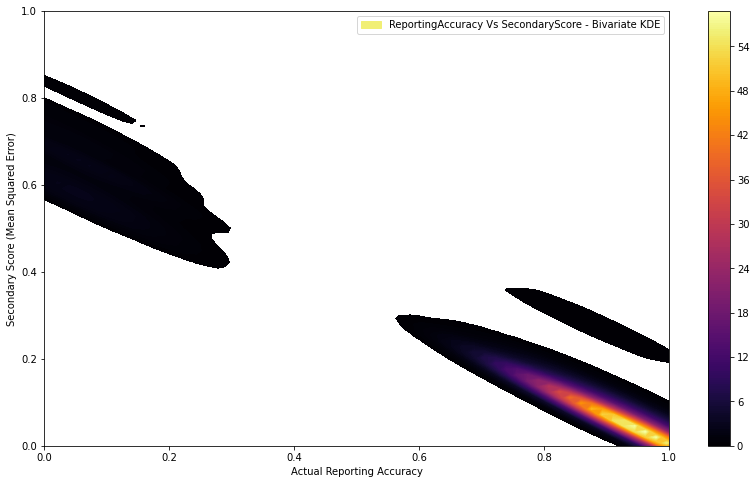

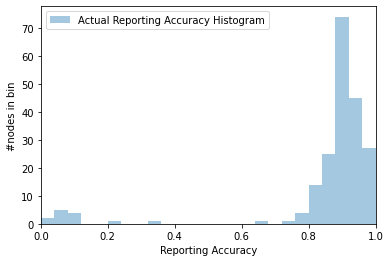

In [9]:

plt.figure(figsize=(14,8))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Actual Reporting Accuracy")
plt.ylabel("Secondary Score (Mean Squared Error)")
sns.kdeplot([i.real for i in evaluatedNodes.values()],
            [i.RSUAvg for i in evaluatedNodes.values()],
            n_levels=200,
            shade=True,
            shade_lowest=False,
            cbar=True,
            #color='black',
            cmap='inferno',
            label="ReportingAccuracy Vs SecondaryScore - Bivariate KDE")
plt.legend() 
plt.savefig('/home/rohan/veins-5.0/examples/myProj1/plots/SCN'+SCNstr+'_ReportingAccuracy_Vs_SecondaryScorea_bivariateKDE.svg')



plt.figure()
plt.xlabel("Reporting Accuracy")
plt.ylabel("#nodes in bin")
plt.xlim(0, 1)
sns.distplot([nodeAcc[i] for i in nodeAcc], kde=False, bins=25, label='Actual Reporting Accuracy Histogram')
plt.legend()


